**ROI MONTERO VÉLEZ Y AUGUSTO PAOLONE**

In [1]:
import tensorflow
tensorflow.test.gpu_device_name()
#Activamos la gpu en la nube

''

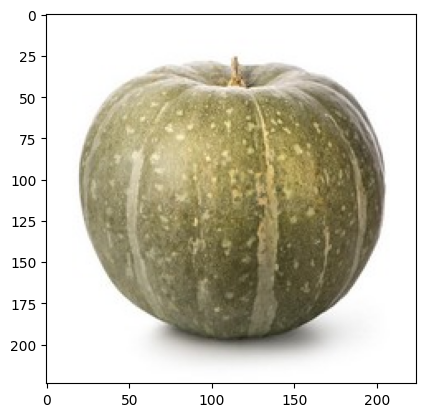

In [2]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('..//input/vegetales-mio/mi_dataset/Pumpkin/Training/1029.jpg', 'r')

#Elegimos una 
imshow(np.asarray(pil_im))

In [3]:

from tensorflow.keras import backend as K
from time import time

# DATA

#Código de las distintas carpetas de datos
train_data_dir = '..//input/vegetales-mio/mi_dataset'
validation_data_dir = '..//input/vegetales-mio/mi_dataset'
test_data_dir = '..//input/vegetales-mio/mi_dataset'
image_size = (150, 150)

#mini_batch
batch_size = 32

#Esto define el tamaño del lote para cada época de entrenamiento, es decir que se procesarán 32 imágenes antes de actualizar nuevamente los pesos.


In [4]:

#Aquí estamos creando datos para los 3 conjuntos de imágenes
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

#Esto permite cargar nuevos datos en segundo plano mientras el actual se esté ejecutando, aumentado la velocidad del proceso
train_ds = train_ds.prefetch(buffer_size=32)

validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 2252 files belonging to 8 classes.
Using 1802 files for training.
Found 2252 files belonging to 8 classes.
Using 450 files for validation.
Found 2252 files belonging to 8 classes.
Using 450 files for validation.


# **Image Augmentation**

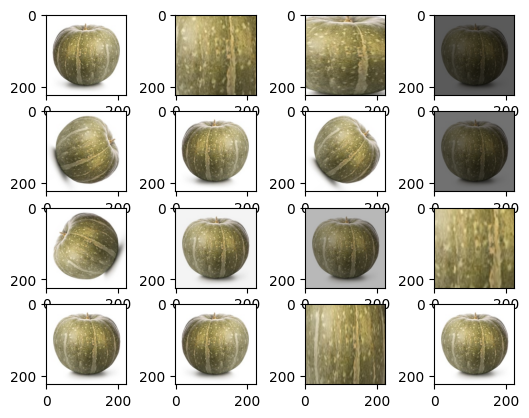

In [5]:
#Aquí demostramos como se hace el Image Augmention aunque nuestra red no la necesita para dar valores óptimos.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
import random

#Imágen
img = load_img('..//input/vegetales-mio/mi_dataset/Pumpkin/Training/1029.jpg')
#Convertir en array numpy (3 dimensiones)
data = img_to_array(img)
#Se le añade una nueva dimensión que es el tamaño del bloque (keras y tensorflow esperan lotes de imágenes)
samples = expand_dims(data, 0)

#Características 
datagen = ImageDataGenerator(rotation_range=90)
datagen2 = ImageDataGenerator(horizontal_flip=True)
datagen3 = ImageDataGenerator(brightness_range=[0.3,1.0])
datagen4 = ImageDataGenerator(zoom_range=[0.2,1.0])

#Crear generador de flujo de datos para cada datagen

it = datagen.flow(samples, batch_size=1)
it2 = datagen2.flow(samples, batch_size=1)
it3 = datagen3.flow(samples, batch_size=1)
it4 = datagen4.flow(samples, batch_size=1)

#Bucle para elegir aleatoriamente alguna variación en 9 imágenes
for i in range(16):
    #Esto hace una matriz 4x4 para poner las imágenes
    pyplot.subplot(4, 4, i + 1)
    iterator = random.choice([it, it2, it3, it4])
    batch = iterator.next()
    #dato entero sin signo 8 bits para poder visualizarla
    image = batch[0].astype('uint8')
    pyplot.imshow(image)
pyplot.show()



**NUESTRO MODELO**

In [6]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    



model = Sequential()

model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))


#Las capas convolutivas Las primeras llevan a cabo un proceso de extracción de características.
#Relu = si la entrada es positiva, la salida es el número, si es negativa, la salida es '0'
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))





model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(8, activation='softmax'))



model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 72, 72, 64)        0         
                                                        

In [7]:

#El optimizador es Adam y lo de dentro es la tasa de aprendizaje, vemos que es una buena tasa ya que el valor de la función de pérdida empieza muy alta y va disminuyendo

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [8]:
#Training
from tensorflow.keras.callbacks import EarlyStopping

epochs = 200


es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

#Fit hace el entrenamiento
history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)


Epoch 1/200
57/57 [==============================] - 62s 1s/step - loss: 1.7169 - accuracy: 0.4628 - val_loss: 1.3137 - val_accuracy: 0.6556
Epoch 2/200
57/57 [==============================] - 58s 1s/step - loss: 0.8564 - accuracy: 0.7170 - val_loss: 0.9925 - val_accuracy: 0.7822
Epoch 3/200
57/57 [==============================] - 58s 1s/step - loss: 0.5957 - accuracy: 0.8013 - val_loss: 0.7177 - val_accuracy: 0.8667
Epoch 4/200
57/57 [==============================] - 58s 1s/step - loss: 0.3892 - accuracy: 0.8696 - val_loss: 0.6972 - val_accuracy: 0.7933
Epoch 5/200
57/57 [==============================] - 58s 1s/step - loss: 0.2760 - accuracy: 0.9134 - val_loss: 0.4586 - val_accuracy: 0.9067
Epoch 6/200
57/57 [==============================] - 58s 1s/step - loss: 0.2580 - accuracy: 0.9151 - val_loss: 0.4143 - val_accuracy: 0.9067
Epoch 7/200
57/57 [==============================] - 58s 1s/step - loss: 0.1575 - accuracy: 0.9556 - val_loss: 0.4226 - val_accuracy: 0.9133
Epoch 8/200
5

In [9]:
#Salvado
model.save("modelo.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#  **Evaluación de resultados**

**MATRIZ**

1/1 [==============================] - 0s 109ms/step
              precision    recall  f1-score   support

           0     0.9375    0.9184    0.9278        49
           1     0.8769    0.9661    0.9194        59
           2     0.9259    0.9259    0.9259        54
           3     0.9811    0.9630    0.9720        54
           4     1.0000    0.9483    0.9735        58
           5     0.8873    0.9844    0.9333        64
           6     0.9474    0.9000    0.9231        60
           7     0.9574    0.8654    0.9091        52

    accuracy                         0.9356       450
   macro avg     0.9392    0.9339    0.9355       450
weighted avg     0.9379    0.9356    0.9357       450



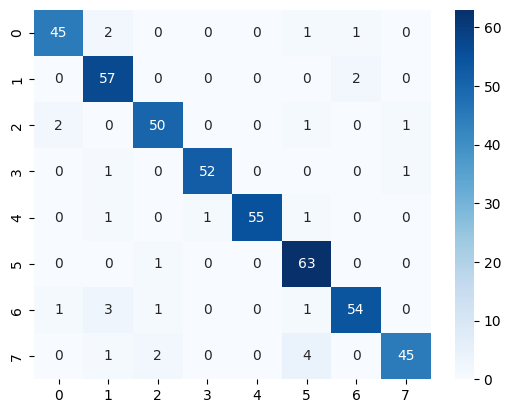

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

**GRÁFICA**

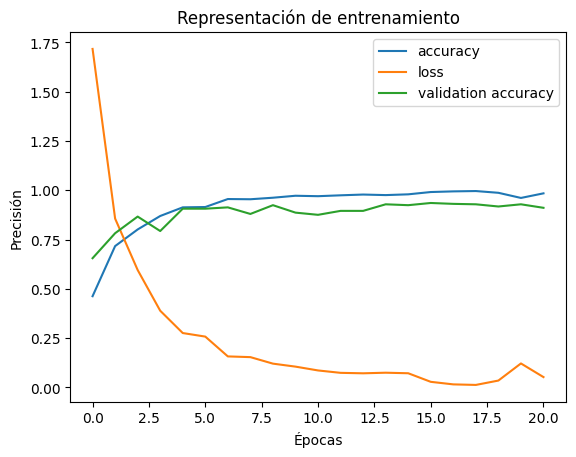

In [11]:
#Gráfica
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.title('Representación de entrenamiento')

plt.ylabel('Precisión')
plt.xlabel('Épocas')
plt.legend(loc="upper right")

plt.show()

(150, 150, 3)
1/1 [==============================] - 0s 129ms/step
El vector de salida obtenido:  [[1.6195165e-02 7.1595032e-03 1.6874937e-02 7.7688326e-03 5.8815122e-04
  2.6352944e-02 9.2005008e-01 5.0103921e-03]]
1/1 [==============================] - 0s 33ms/step
La etiqueta de salida predicha es  6
1/1 [==============================] - 0s 38ms/step
Ahora dicho con texto: La etiqueta de salida predicha es  Pumpkin


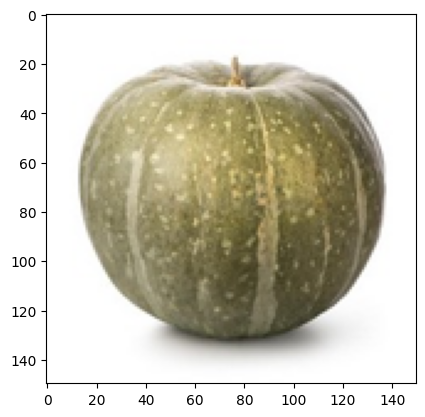

In [12]:

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

#Cargando

etiquetas=['Brocoli', 'Cabbage', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Tomato']
%matplotlib inline

pil_im = Image.open('..//input/vegetales-mio/mi_dataset/Pumpkin/Training/1029.jpg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape)

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3
#La imagen tiene el valor 150x150x3 

im = im.reshape(1,150,150,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






**PRODUCCIÓN**

In [13]:
import numpy as np
import tensorflow.keras

etiquetas=['Brocoli', 'Cabbage', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Tomato']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")

#Por cada minilote realiza predicciones utilizando el modelo y las imprime
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy() #Contiene las etiquetas reales
    #itera sobre las etiquetas predichas y las reales 
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote): 
        #Compara el índice de la clase con la probabilidad más alta ne las etiqueras predichas y reales y si coinciden, la predicción es correcta
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL
1/1 [==============================] - 0s 257ms/step
Cucumber -> Cucumber
Papaya -> Papaya
Pumpkin -> Pumpkin
Brocoli -> Brocoli
Papaya -> Papaya
Potato -> Potato
Tomato -> Tomato
Pumpkin -> Pumpkin
Cabbage -> Cabbage
Cauliflower -> Cauliflower
Papaya -> Papaya
Potato -> Potato
Brocoli -> Brocoli
Tomato -> Tomato
Pumpkin -> Pumpkin
Cauliflower -> Cauliflower
Papaya -> Papaya
Brocoli -> Brocoli
Papaya -> Papaya
Pumpkin -> Pumpkin
Cauliflower -> Cauliflower
Pumpkin -> Pumpkin
Tomato -> Tomato
Potato -> Potato
Pumpkin -> Pumpkin
Pumpkin -> Pumpkin
Cauliflower -> Cauliflower
Pumpkin -> Pumpkin
Brocoli -> Brocoli
Cabbage -> Cabbage
Potato -> Potato
Cabbage -> Cabbage
1/1 [==============================] - 0s 227ms/step
Pumpkin -> Pumpkin
Potato -> Potato
Cucumber -> Cucumber
Potato -> Tomato ✘
Tomato -> Tomato
Pumpkin -> Pumpkin
Brocoli -> Brocoli
Cauliflower -> Cauliflower
Cucumber -> Cucumber
Papaya -> Papaya
Brocoli -> Brocoli
Cucumber -> Cucumber
Cucum